# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, we will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. We'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, we'll apply what we've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that we will use has been provided by Bertelsmann Arvato Analytics.

In [1]:
# import neccessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# scikit learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

# magic word for producing visualizations in notebook
%matplotlib inline

## Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. We use the information from the first two files to figure out how customers (<span class="mark">"CUSTOMERS"</span>) are similar to or differ from the general population at large ("AZDIAS"), then we use our analysis to make predictions on the other two files (<span class="mark">"MAILOUT"</span>), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns (<span class="girk">'CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'</span>), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed.

In [2]:
# load in the data
azdias = pd.read_csv('data/azdias.csv')
customers = pd.read_csv('data/customer.csv')

/opt/anaconda3/envs/DataScience/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Columns <span class="girk">'CAMEO_DEUG_2015'</span> and <span class="girk">'CAMEO_INTL_2015'</span> have mixed datatypes, which we are going to fix.

In [3]:
def mixed_datatypes_handler(dataframes, mixed_datatypes):
    """
    Takes as input a dictionary (mixed_datatypes) and makes specific columns consistent.
    
    args: 
    - mixed_datatypes: dict with keys=columns and values=attributes
    - dataframes: pandas Dataframes
    """
    for key, value in mixed_datatypes.items():
        for frame in dataframes:
            frame[key].replace(value, [float(i) for i in value], inplace=True)

In [4]:
# Same attributes are sometimes encoded as strings and sometimes as floats, e.g., 1 and '1'
mixed_datatypes = {'CAMEO_DEUG_2015': [str(i) for i in range(1,10)], 
                   'CAMEO_INTL_2015': ['22', '24', '41', '12', '54', '51', '44', '35', '23', 
                                       '25', '14','34', '52', '55', '31', '32', '15', '13',
                                       '43', '33', '45']}

mixed_datatypes_handler([azdias, customers], mixed_datatypes)

### General Information
Display some summary statistics and information about both datasets, <span class="mark">azdias</span> and <span class="mark">customers</span>.

In [5]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [6]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


Next, we get some information about the dtypes and shapes of <span class="mark">"azdias"</span> and <span class="mark">"customers"</span>

In [7]:
print(azdias.info())
print()
print(customers.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB
None


In [8]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [9]:
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


### First look at features
First, we have a look at the number of features in each dataset. Afterwards, we identify the common features.
Since there are only three columns that both datasets do not have in common, we discard them.

In [10]:
common_attributes = set(customers.columns).intersection(set(azdias.columns))
print("Number of attributes for 'azdias': {}".format(len(azdias.columns)))
print("Number of attributes for 'customers': {}".format(len(customers.columns)))
print("Number of common attributes: {}".format(len(common_attributes)))

Number of attributes for 'azdias': 366
Number of attributes for 'customers': 369
Number of common attributes: 366


In [11]:
# we store the uncommon variables as a global variable
NOT_COMMON_ATTRIBUTES = list(set(customers.columns).symmetric_difference(set(azdias.columns)))
print("Not common attributes: {}".format(NOT_COMMON_ATTRIBUTES))

Not common attributes: ['ONLINE_PURCHASE', 'PRODUCT_GROUP', 'CUSTOMER_GROUP']


In [12]:
# Delete columns that datasets do not have in common
customers.drop(NOT_COMMON_ATTRIBUTES, axis=1, inplace=True)

Next, we will have a look at the categorical attributes of <span class="mark">azdias</span> and <span class="mark">customers</span>, respectively.

In [13]:
print('Cat. attributes azdias:', azdias.select_dtypes(include=['object']).columns.values)
print()
print('Cat. attributes customers:', customers.select_dtypes(include=['object']).columns.values)

Cat. attributes azdias: ['CAMEO_DEU_2015' 'CAMEO_DEUG_2015' 'CAMEO_INTL_2015'
 'D19_LETZTER_KAUF_BRANCHE' 'EINGEFUEGT_AM' 'OST_WEST_KZ']

Cat. attributes customers: ['CAMEO_DEU_2015' 'CAMEO_DEUG_2015' 'CAMEO_INTL_2015'
 'D19_LETZTER_KAUF_BRANCHE' 'EINGEFUEGT_AM' 'OST_WEST_KZ']


The column <span class="girk">'EINGEFUEGT_AM'</span> doesn't seem that meaningful. Therefore, we discard that attribute from both datasets.

In [14]:
azdias.drop(['EINGEFUEGT_AM'], axis=1, inplace=True)
customers.drop(['EINGEFUEGT_AM'], axis=1, inplace=True)

Some of the categorical attributes contain values that do not have an encoded meaning.

In [15]:
def attributes_to_replace(dataframes, attr_to_replace):
    """
    Replace specific values in specific column by Nan values.
    
    args:
    - attr_to_replace: dict with key=columns and values=attributes
    - dataframes: pandas Dataframes
    """
    for key, value in attr_to_replace.items():
        for frame in dataframes:
            frame[key].replace(value, np.nan, inplace=True)

In [16]:
# Some of the columns have attributes that do not occur in DIAS-Attributes
col_attr_to_replace = {'CAMEO_DEU_2015': 'XX', 'CAMEO_DEUG_2015': 'X', 'CAMEO_INTL_2015': 'XX'}

attributes_to_replace([azdias, customers], col_attr_to_replace)

## Get to know the description of the data

We read in the description of the data, i.e., <span class="mark">'DIAS Attributes - Values 2017'</span>, and use it to identify additional missing values in our dataframes.

In [17]:
info_table = pd.read_excel('DIAS Attributes - Values 2017.xlsx',header=1).drop(['Unnamed: 0'], axis=1)
info_table.Attribute = info_table.Attribute.ffill()
info_table.Description = info_table.Description.ffill()
info_table.Meaning = info_table.Meaning.ffill()

info_table.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


As we can see, some attributes encode numbers as missing or unknown values. 

For example: the value <span class="burk">'-1'</span> in the attribute <span class="girk">'AGER_TYP'</span>

Therefore, we create a dictionary, called <span class="mark">'value_meaning'</span>, to gather these information.

In [18]:
# dict of attributes with the corresponding value that indicates that its meaning is unknown or missing
value_meaning = {}
for index, row in info_table.iterrows():
    if 'unknown' in row.Meaning:
        value_meaning[row.Attribute] = list(map(lambda x: int(x), str(row.Value).split(',')))

Next, we replace all unknown values in the corresponding columns by NaN values, i.e., np.nan.

In [19]:
def add_nans(dataframes, nan_values):
    """
    Replaces unknown values with np.nan.
    
    args: 
    - nan_values: dict with keys=attributes and values=unknown values
    - dataframes: pandas Dataframes
    """
    for frame in dataframes:
        for col in frame.columns:
            if col in nan_values.keys():
                value = nan_values[col]
                if value != None:
                    frame[col].replace(value, np.nan, inplace=True)

In [20]:
# replace unknown values by np.nan
add_nans([azdias, customers], value_meaning)

## Missing values

In this section, we investigate the distribution of missing values over the attributes in both dataframes. We decide on which attributes to discard from the dataframes and we will investigate how to fill in missing values.

### Distribution of missing values

In [21]:
# Determine the distribution of missing values in 'azdias'
azdias_missing_relative = [round(pd.isnull(azdias[col]).values.sum()/azdias.shape[0],2)*100 for col in azdias.columns]
azdias_missing_total = list(map(lambda x: int(x*azdias.shape[0]), azdias_missing_relative))

azdias_missing = {'total': azdias_missing_total, 'relative': azdias_missing_relative}
azdias_missing_df = pd.DataFrame(azdias_missing, index=azdias.columns)
azdias_missing_df = azdias_missing_df.sort_values(by=['relative'], ascending=False)

azdias_missing_df.head()

,total,relative
TITEL_KZ,89122100,100.0
ALTER_KIND4,89122100,100.0
ALTER_KIND3,88230879,99.0
ALTER_KIND2,86448437,97.0
ALTER_KIND1,81101111,91.0


In [22]:
# Determine the distribution of missing values in 'customers'
customers_missing_relative = [round(pd.isnull(customers[col]).values.sum()/customers.shape[0],2)*100 for col in customers.columns]
customers_missing_total = list(map(lambda x: int(x*customers.shape[0]), customers_missing_relative))

customers_missing = {'total': customers_missing_total, 'relative': customers_missing_relative}
customers_missing_df = pd.DataFrame(customers_missing, index=customers.columns)
customers_missing_df = customers_missing_df.sort_values(by=['relative'], ascending=False)

customers_missing_df.head()

,total,relative
ALTER_KIND4,19165200,100.0
TITEL_KZ,18973548,99.0
ALTER_KIND3,18973548,99.0
ALTER_KIND2,18590244,97.0
ALTER_KIND1,18015288,94.0


Since the attributes <span class="girk">'ALTER_KIND1'</span> until <span class="girk">'ALTER_KIND4'</span> hava a high percentage of missing values, we replace these features by a new feature, called <span class="mark">'MEAN_ALTER_KIND'</span>, measuring the mean age of all kids in a household.

In [23]:
df_azdias_kind = azdias[['ALTER_KIND1','ALTER_KIND2','ALTER_KIND3','ALTER_KIND4']]
azdias['ALTER_KIND_MEAN'] = np.sum(df_azdias_kind, axis=1)

azdias['ALTER_KIND_MEAN'].loc[df_azdias_kind.isnull().sum(axis=1) == 2] = azdias[df_azdias_kind.isnull().sum(axis=1) == 2]['ALTER_KIND_MEAN']/2
azdias['ALTER_KIND_MEAN'].loc[df_azdias_kind.isnull().sum(axis=1) == 1] = azdias[df_azdias_kind.isnull().sum(axis=1) == 1]['ALTER_KIND_MEAN']/3
azdias['ALTER_KIND_MEAN'].loc[df_azdias_kind.isnull().sum(axis=1) == 0] = azdias[df_azdias_kind.isnull().sum(axis=1) == 0]['ALTER_KIND_MEAN']/4

azdias.drop(['ALTER_KIND1','ALTER_KIND2','ALTER_KIND3','ALTER_KIND4'], axis=1, inplace=True)

/opt/anaconda3/envs/DataScience/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [24]:
df_customers_kind = customers[['ALTER_KIND1','ALTER_KIND2','ALTER_KIND3','ALTER_KIND4']]
customers['ALTER_KIND_MEAN'] = np.sum(df_customers_kind, axis=1)

customers['ALTER_KIND_MEAN'].loc[df_customers_kind.isnull().sum(axis=1) == 2] = customers[df_customers_kind.isnull().sum(axis=1) == 2]['ALTER_KIND_MEAN']/3
customers['ALTER_KIND_MEAN'].loc[df_customers_kind.isnull().sum(axis=1) == 1] = customers[df_customers_kind.isnull().sum(axis=1) == 1]['ALTER_KIND_MEAN']/3
customers['ALTER_KIND_MEAN'].loc[df_customers_kind.isnull().sum(axis=1) == 0] = customers[df_customers_kind.isnull().sum(axis=1) == 0]['ALTER_KIND_MEAN']/4

customers.drop(['ALTER_KIND1','ALTER_KIND2','ALTER_KIND3','ALTER_KIND4'], axis=1, inplace=True)

In [25]:
azdias_missing_df.drop(['ALTER_KIND1','ALTER_KIND2','ALTER_KIND3','ALTER_KIND4'], inplace=True)
customers_missing_df.drop(['ALTER_KIND1','ALTER_KIND2','ALTER_KIND3','ALTER_KIND4'], inplace=True)

Let us now revisit the distribution of missing values.

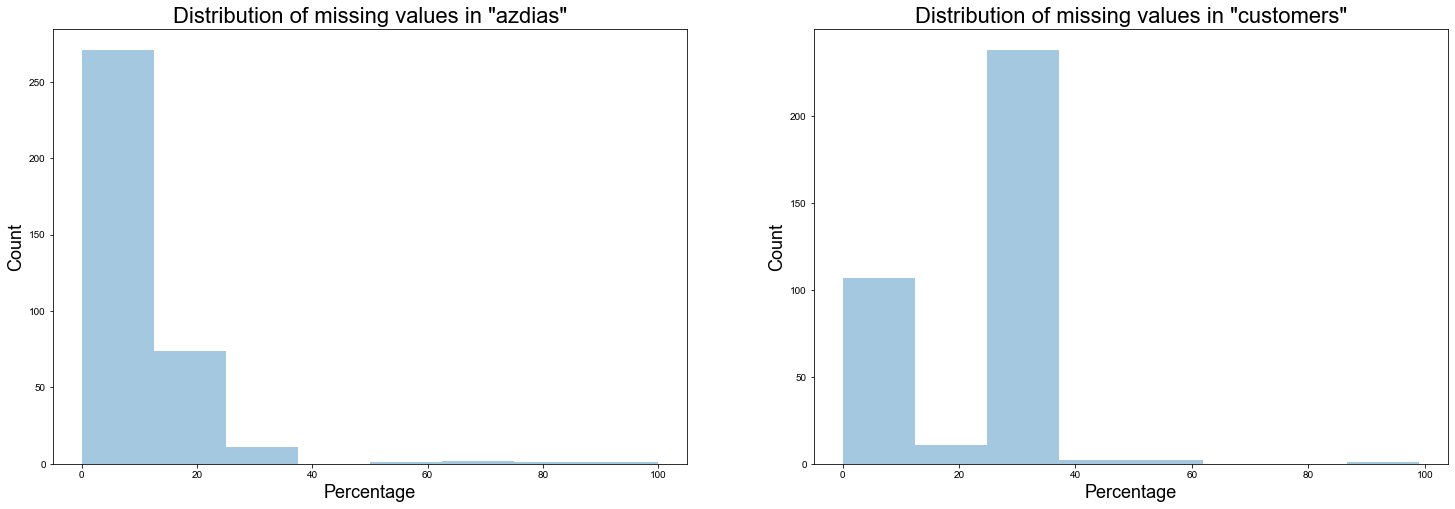

In [26]:
f, axes = plt.subplots(1, 2, figsize=(25, 8))
chart = sns.distplot(azdias_missing_df['relative'], 8, kde=False, ax=axes[0])
axes[0].set_title('Distribution of missing values in "azdias"', fontsize=22)
axes[0].set_ylabel('Count', fontsize=18)
axes[0].set_xlabel('Percentage', fontsize=18)

chart = sns.distplot(customers_missing_df['relative'], 8, kde=False, ax=axes[1])
axes[1].set_title('Distribution of missing values in "customers"', fontsize=22)
axes[1].set_ylabel('Count', fontsize=18)
axes[1].set_xlabel('Percentage', fontsize=18)
sns.set_style('darkgrid')
f.savefig("pictures/missing_values.pdf",format='pdf', bbox_inches='tight')

The barplots displayed above indicate that most of the data features of both datasets have less than 40% missing data.
After testing some percentage values, it seems like 31% is the lowest possible threshold such that both datasets have the same features with less than 31% of missing data.

In [27]:
threshold_missing = 31

print("Number of features with less than {}% missing data for azdias:".format(threshold_missing))
print(len(azdias_missing_df[azdias_missing_df['relative'] <= threshold_missing]))
print()
print("Number of features with less than {}% missing data for customers:".format(threshold_missing))
print(len(customers_missing_df[customers_missing_df['relative'] <= threshold_missing]))
print()
print("Both datasets have the same features with less than {}% missing data:".format(threshold_missing))
print(set(azdias_missing_df[azdias_missing_df['relative'] <= threshold_missing].index) == set(customers_missing_df[customers_missing_df['relative'] <= threshold_missing].index))    

Number of features with less than 31% missing data for azdias:
355

Number of features with less than 31% missing data for customers:
355

Both datasets have the same features with less than 31% missing data:
True


The figure below displays the attributes that we are going to remove.

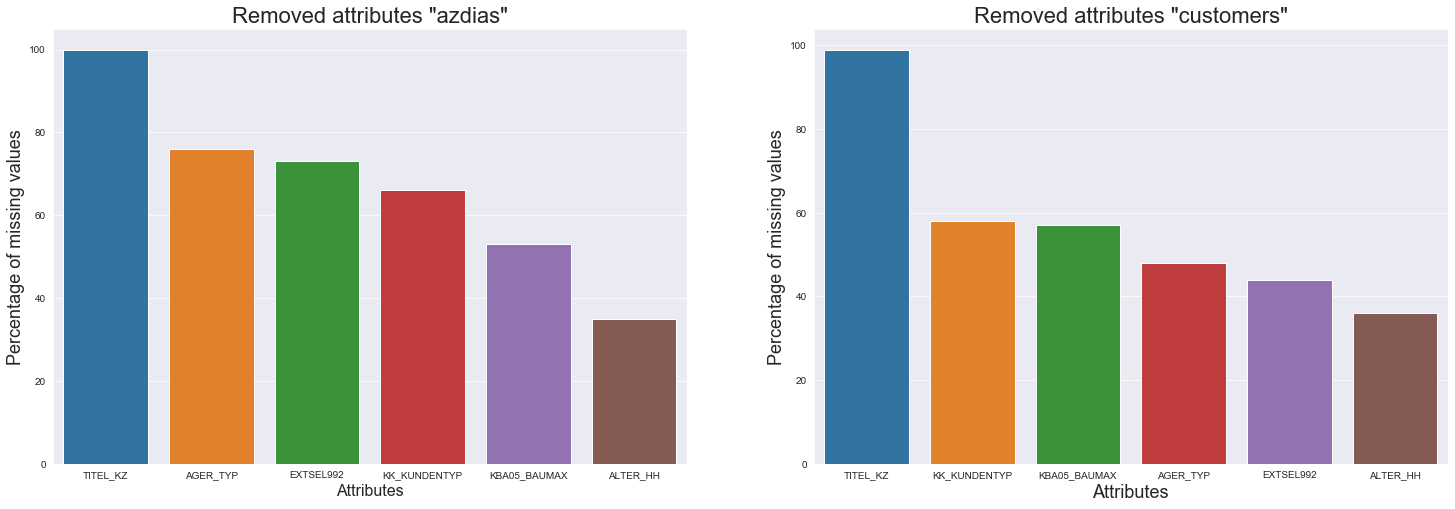

In [28]:
f, axes = plt.subplots(1, 2, figsize=(25, 8))
chart = sns.barplot(azdias_missing_df[azdias_missing_df['relative'] > threshold_missing].index, 
                    azdias_missing_df[azdias_missing_df['relative'] > threshold_missing]['relative'],
                   ax=axes[0])
chart.set_title('Removed attributes "azdias"', fontsize=22)
chart.set_xlabel('Attributes', fontsize=16)
chart.set_ylabel('Percentage of missing values', fontsize=18)

chart1 = sns.barplot(customers_missing_df[customers_missing_df['relative'] > threshold_missing].index, 
                    customers_missing_df[customers_missing_df['relative'] > threshold_missing]['relative'],
                   ax=axes[1])
chart1.set_title('Removed attributes "customers"', fontsize=22)
chart1.set_xlabel('Attributes', fontsize=18)
chart1.set_ylabel('Percentage of missing values', fontsize=18);
f.savefig("pictures/missing_values1.pdf",format='pdf', bbox_inches='tight')

In [29]:
# Identify the attributes with more than 31% of missing data and discard them from both datasets.
old_features = azdias_missing_df.index.values
new_features = azdias_missing_df[azdias_missing_df['relative'] <= threshold_missing].index.values
attributes_to_discard = list(set(old_features).symmetric_difference(set(new_features)))

# Delete columns
customers.drop(attributes_to_discard, axis=1, inplace=True)
azdias.drop(attributes_to_discard, axis=1, inplace=True)
print("Discarded attributes: {}".format(attributes_to_discard))

Discarded attributes: ['ALTER_HH', 'EXTSEL992', 'TITEL_KZ', 'KK_KUNDENTYP', 'AGER_TYP', 'KBA05_BAUMAX']


### Categorical data

First, we investigate the distribution of the categorical values.

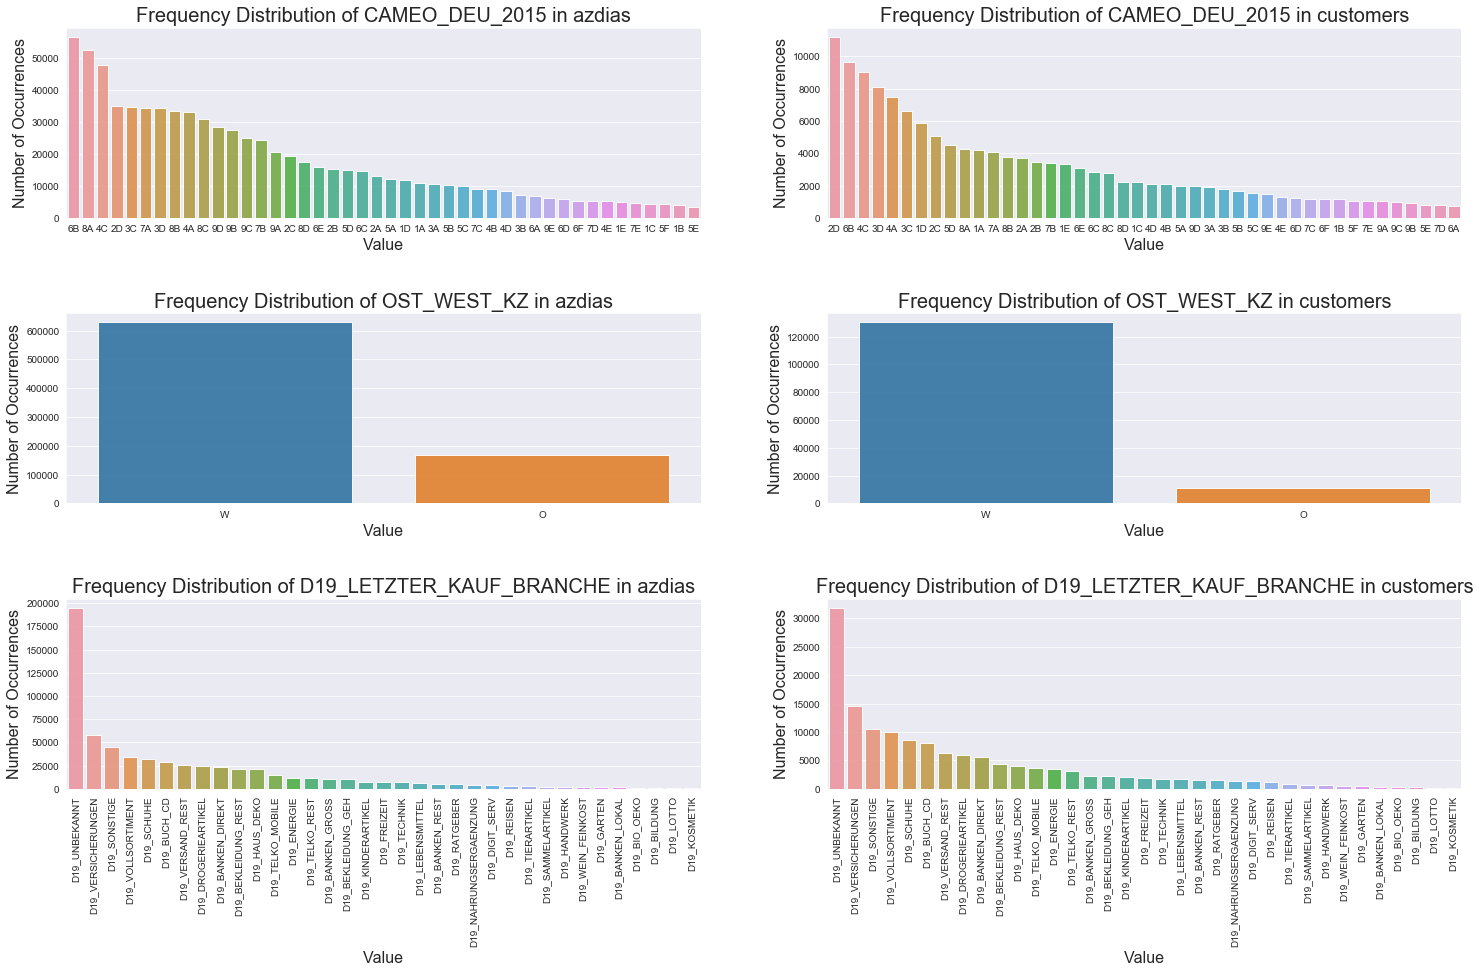

In [30]:
cat_cols = azdias.select_dtypes(include=['object']).columns.values
cat_cols[1], cat_cols[2] = cat_cols[2], cat_cols[1]

f, axes = plt.subplots(len(cat_cols), 2, figsize=(25, 14))
plt.subplots_adjust(hspace=0.5)

for i in range(len(cat_cols)):
    for j in range(2):
        if j == 0:
            chart = sns.barplot(azdias[cat_cols[i]].value_counts().index, azdias[cat_cols[i]].value_counts(), alpha=0.9, ax=axes[i][j])
            axes[i][j].set_title('Frequency Distribution of {} in azdias'.format(cat_cols[i]), fontsize=20)
            axes[i][j].set_ylabel('Number of Occurrences', fontsize=16)
            axes[i][j].set_xlabel('Value', fontsize=16)
            if i == 2:
                axes[i][j].set_xticklabels(azdias[cat_cols[i]].value_counts().index, rotation=90)
            
        if j == 1:
            chart = sns.barplot(customers[cat_cols[i]].value_counts().index, customers[cat_cols[i]].value_counts(), alpha=0.9, ax=axes[i][j])
            axes[i][j].set_title('Frequency Distribution of {} in customers'.format(cat_cols[i]), fontsize=20)
            axes[i][j].set_ylabel('Number of Occurrences', fontsize=16)
            axes[i][j].set_xlabel('Value', fontsize=16)
            if i == 2:
                axes[i][j].set_xticklabels(azdias[cat_cols[i]].value_counts().index, rotation=90)

f.savefig("pictures/categorical_variables.pdf",format='pdf', bbox_inches='tight')            

### Fill in missing values

We replace missing values depending on the dtype of the corresponding attribute.

In [31]:
def replace_nans(dataframes):
    """
    Replace NaNs in each dataframe depending on the attributes dtype.
    
    args: 
    - dataframes
    """
    for frame in dataframes:
        for col in frame.columns:
            if frame[col].dtype == 'object':
                frame[col].replace(np.nan, frame[col].value_counts(ascending=False).index[0], inplace=True)
            else:
                frame[col].replace(np.nan, frame[col].mean(), inplace=True)
                
        if True in [True in pd.isnull(frame[col]).values for col in frame.columns]:
            print("There are still missing values.")
        else:
            print("There are no missing values anymore.")

In [32]:
replace_nans([azdias, customers])

There are no missing values anymore.
There are no missing values anymore.


### Create dummy variables

For all categorical attributes of <span class="mark">'azdias'</span> and <span class="mark">'customers'</span>, we create dummy-variables.

In [33]:
cat_cols_azdias = azdias.select_dtypes(include=['object']).columns.values

In [34]:
azdias = pd.get_dummies(azdias, columns=cat_cols_azdias)

In [35]:
azdias.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,OST_WEST_KZ_O,OST_WEST_KZ_W
0,910215,4.421928,13.700717,8.287263,0.040647,0.154018,1.727637,7.599356,0.004162,3.167854,...,0,0,0,1,0,0,0,0,0,1
1,910220,9.000000,21.000000,11.000000,0.000000,0.000000,2.000000,12.000000,0.000000,3.000000,...,0,0,0,1,0,0,0,0,0,1
2,910225,9.000000,17.000000,10.000000,0.000000,0.000000,1.000000,7.000000,0.000000,3.000000,...,0,0,0,1,0,0,0,0,0,1
3,910226,1.000000,13.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000,...,0,0,0,1,0,0,0,0,0,1
4,910241,1.000000,14.000000,3.000000,0.000000,0.000000,4.000000,3.000000,0.000000,4.000000,...,0,0,0,0,0,0,0,0,0,1


In [36]:
cat_cols_customers = customers.select_dtypes(include=['object']).columns.values

In [37]:
customers = pd.get_dummies(customers, columns=cat_cols_customers)

In [38]:
customers.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,OST_WEST_KZ_O,OST_WEST_KZ_W
0,9626,1.0,10.000000,1.000000,0.000000,0.0,2.0,1.000000,0.0,1.00000,...,0,0,0,1,0,0,0,0,0,1
1,9628,9.0,10.331579,4.965863,0.067413,0.0,3.0,4.701288,0.0,2.82485,...,0,0,0,0,0,0,0,0,0,1
2,143872,1.0,0.000000,1.000000,0.000000,0.0,1.0,1.000000,0.0,3.00000,...,0,0,0,1,0,0,0,0,0,1
3,143873,1.0,8.000000,0.000000,0.067413,0.0,0.0,1.000000,0.0,1.00000,...,0,0,0,0,0,0,0,0,0,1
4,143874,1.0,14.000000,7.000000,0.000000,0.0,4.0,7.000000,0.0,3.00000,...,0,0,0,0,0,0,0,0,0,1


Lets check for common attributes, again.

In [39]:
common_attributes = set(customers.columns).intersection(set(azdias.columns))
print("Number of attributes for 'azdias': {}".format(len(azdias.columns)))
print("Number of attributes for 'customers': {}".format(len(customers.columns)))
print("Number of common attributes: {}".format(len(common_attributes)))

Number of attributes for 'azdias': 434
Number of attributes for 'customers': 434
Number of common attributes: 434


## Normalization of the data

We scale and translate each feature individually such that it is in the given range between 0 and 1.

In [40]:
scaler = MinMaxScaler()

azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias.loc[:, azdias.columns != 'LNR'].astype(float)))

azdias_scaled.columns = azdias.columns[1:]
azdias_scaled.index = azdias.index

azdias_scaled.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,OST_WEST_KZ_O,OST_WEST_KZ_W
0,0.427741,0.548029,0.013928,0.001767,0.014002,0.038392,0.016925,0.000694,0.270982,0.525507,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.840000,0.018487,0.000000,0.000000,0.044444,0.026726,0.000000,0.250000,0.833333,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.000000,0.680000,0.016807,0.000000,0.000000,0.022222,0.015590,0.000000,0.250000,0.166667,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.000000,0.520000,0.001681,0.000000,0.000000,0.000000,0.004454,0.000000,0.125000,0.500000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.000000,0.560000,0.005042,0.000000,0.000000,0.088889,0.006682,0.000000,0.375000,0.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [41]:
customers_scaled = pd.DataFrame(scaler.fit_transform(customers.loc[:, customers.columns != 'LNR'].astype(float)))

customers_scaled.columns = customers.columns[1:]
customers_scaled.index = customers.index

customers_scaled.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,OST_WEST_KZ_O,OST_WEST_KZ_W
0,0.0,0.400000,0.001912,0.000000,0.0,0.095238,0.002667,0.0,0.000000,0.333333,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.413263,0.009495,0.002931,0.0,0.142857,0.012537,0.0,0.228106,0.550293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.000000,0.001912,0.000000,0.0,0.047619,0.002667,0.0,0.250000,1.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.320000,0.000000,0.002931,0.0,0.000000,0.002667,0.0,0.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.560000,0.013384,0.000000,0.0,0.190476,0.018667,0.0,0.250000,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Unsupervised learning

Here, we aim at investigating the relationship between the demographics of the company's existing customers and the general population of Germany.

First, we use PCA (Principal Component Analysis) to reduce the dimensionality of the input.

In [42]:
pca = PCA()
pca = pca.fit(azdias_scaled)

Next, we investigate the cumulative explained variance.

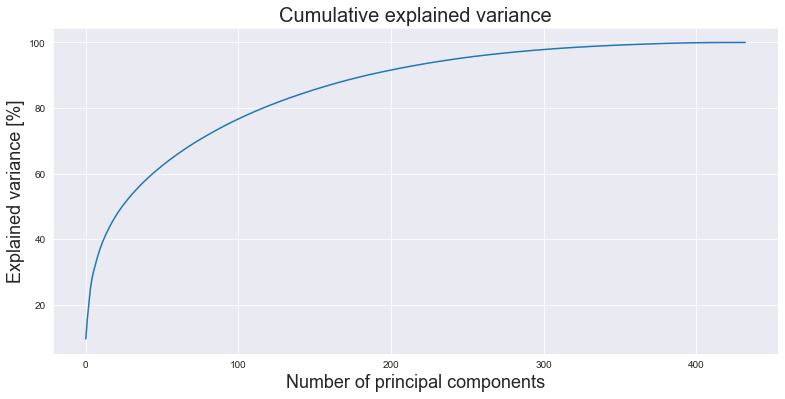

In [43]:
plt.figure(figsize=(13,6))
plt.plot(pca.explained_variance_ratio_.cumsum()*100)
plt.ylabel('Explained variance [%]', fontsize=18)
plt.xlabel('Number of principal components', fontsize=18)
plt.title('Cumulative explained variance', fontsize=20);
plt.savefig("pictures/pca_explained_var.pdf",format='pdf', bbox_inches='tight')

It seems like using ca. 50 PC´s are sufficient to cover at least 60% of the explained variance.

In [44]:
pca = PCA(n_components=50)
pca_azdias = pca.fit_transform(azdias_scaled)

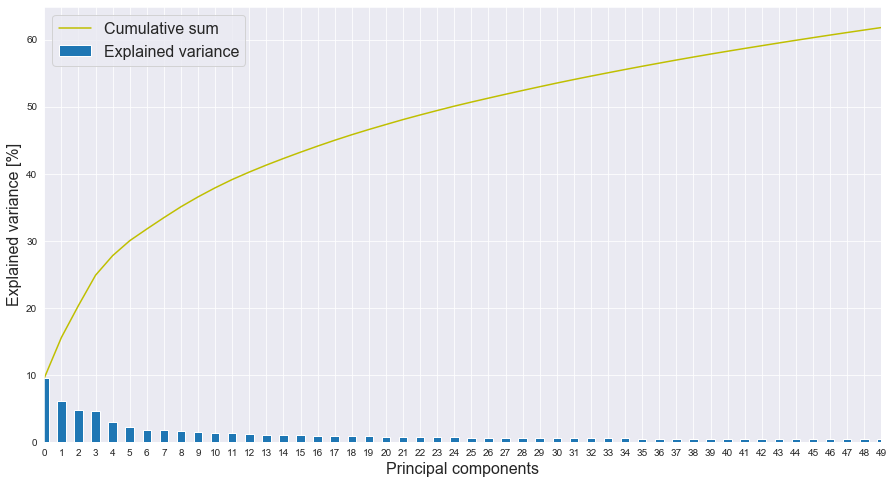

In [45]:
df_expl_var = pd.DataFrame({'Explained variance': pca.explained_variance_ratio_*100,
                           'Cumulative sum': pca.explained_variance_ratio_.cumsum()*100})

fig, ax1 = plt.subplots(figsize=(15, 8))
df_expl_var['Explained variance'].plot(kind='bar')
df_expl_var['Cumulative sum'].plot(kind='line', color='y')
ax1.set_ylabel('Explained variance [%]', fontsize=16)
ax1.set_xlabel('Principal components', fontsize=16)
ax1.legend(fontsize=16);
plt.savefig("pictures/pca_explained_var1.pdf",format='pdf', bbox_inches='tight')

In [46]:
pca_azdias_df = pd.DataFrame(pca_azdias)
pca_azdias_df.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.889231,-1.212948,-0.459352,-0.106260,-0.080578,-0.067496,-0.800018,-0.341347,-0.917161,0.079921,...,-0.134331,0.127537,0.016632,0.082829,0.013709,-0.079945,0.286013,-0.086009,0.169322,0.341037
1,-1.692933,1.158736,-1.909580,0.958060,-0.556953,-0.052640,1.809899,-0.573196,0.051587,0.166470,...,-0.296104,0.258799,-0.274077,-0.362115,0.563235,0.016603,-0.100693,0.041395,-0.215425,-0.043377
2,-0.201827,-0.270228,-1.174721,0.400810,-0.955790,1.193301,-0.252199,0.764354,2.285943,0.134135,...,0.368373,-0.266107,-0.083701,0.013640,-0.413921,0.489369,0.119932,-0.201236,0.028878,-0.420412
3,1.103108,-1.983901,-0.613975,-0.088098,-0.404010,-0.127867,0.879294,-0.186178,0.520890,-0.884314,...,0.314243,-0.342347,-0.166710,0.391914,-0.050239,0.332648,-0.311835,0.451634,0.220425,0.000598
4,1.788747,1.915487,1.107773,1.357634,0.850341,-0.786535,-1.080181,-0.403903,0.071690,-0.609224,...,0.237752,-0.109711,-0.621390,-0.002742,-0.313480,0.204859,0.930105,0.135229,0.251372,0.047612


In [47]:
pca_customers = pca.transform(customers_scaled)

In [48]:
pca_customers_df = pd.DataFrame(pca_customers)
pca_customers_df.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,2.050476,-2.478352,-0.202842,1.026949,1.083766,-0.124133,-0.063484,0.197773,-0.050352,-0.421774,...,-0.476832,-0.526977,-0.106132,-0.227248,-0.444847,0.007270,-0.128748,0.030684,0.208547,-0.026531
1,0.698575,-1.150411,0.167723,0.514235,0.844849,-0.031555,-0.221255,0.037004,-0.061808,0.082733,...,-0.033102,-0.191881,0.033540,0.248555,-0.159757,0.034325,0.202992,-0.143764,-0.121171,-0.600059
2,-0.399226,-1.970682,0.921373,1.458805,-0.670800,-0.507855,-0.256416,0.776096,-1.016510,-1.542626,...,0.051687,0.635717,-0.170363,0.163850,0.952580,-0.400581,-0.033758,-0.244437,0.620523,-0.060300
3,1.514125,-1.865741,0.537896,-0.632350,1.004272,0.400652,-0.235975,-1.228547,0.501337,-0.432757,...,0.378268,-0.262042,0.429958,0.065425,0.291027,-0.297166,-0.342600,0.018491,-0.522630,0.040278
4,1.095401,2.257813,1.180614,0.190090,0.429136,-1.564168,-0.530650,-0.202483,-0.186023,0.489905,...,-0.193120,0.187615,0.128644,0.431051,0.032900,0.001283,-0.305990,0.258723,0.376012,-0.536697


Next, we use KMeans-Clustering to identify groups within the data. We use MiniBatchKMeans to speed up computation time. Further, as a measurement for the error, we use inertia, which is defined as the sum of square distances of samples to their nearest neighbor.

In [49]:
K = range(1,50)
inertia = []
for k in K:
    kmeans = MiniBatchKMeans(n_clusters=k,random_state=0)
    kmeans.fit(pca_azdias_df)
    inertia.append(kmeans.inertia_)

In the figure below, we conduct the <span class="girk">Elbow Method</span> to identify the optimal number of clusters to use for our analysis.

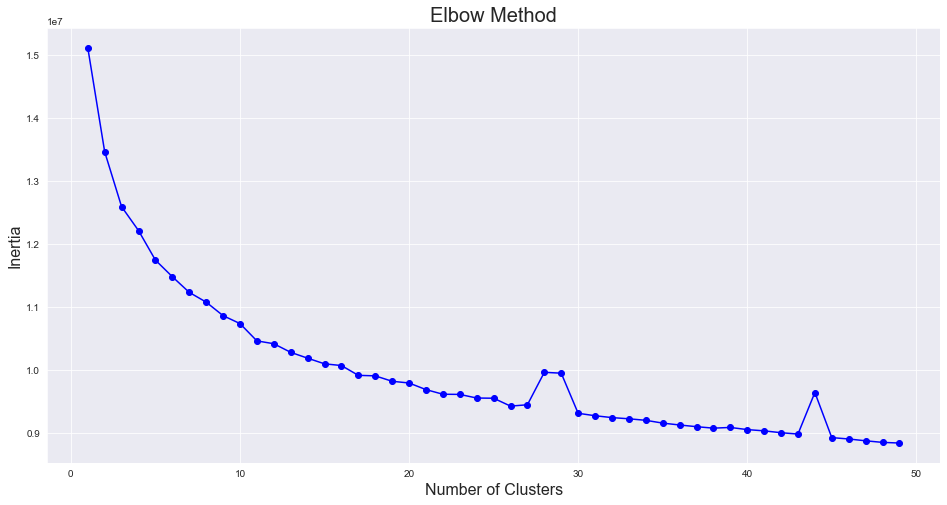

In [50]:
plt.figure(figsize=(16,8))
plt.plot(K, inertia, '-bo')
plt.xlabel('Number of Clusters', fontsize=16)
plt.ylabel('Inertia', fontsize=16)
plt.title('Elbow Method', fontsize=20)
plt.savefig("pictures/elbow_method.pdf",format='pdf', bbox_inches='tight')
plt.show()

We choose <span class="mark">k=17</span> for our final KMeans model.

In [51]:
opt_k = 17
kmeans_model = KMeans(n_clusters=opt_k).fit(pca_azdias_df)

In [52]:
kmeans_model_customers = kmeans_model.predict(pca_customers_df)

Next, we calculate the cluster distribution among the individuals in <span class="mark">azdias</span> and <span class="mark">customers</span>.

In [53]:
# distribution of different classes in customers and azdias
count = pd.Series(kmeans_model.labels_).value_counts().append(pd.Series(kmeans_model_customers).value_counts())
cluster = pd.Series(kmeans_model.labels_).value_counts().index.append(pd.Series(kmeans_model_customers).value_counts().index)

kmeans_results = {'count': count,
                  'class': ['azdias']*opt_k + ['customers']*opt_k,
                  'cluster': cluster
                 }
kmeans_results = pd.DataFrame(kmeans_results)
kmeans_results['percentage'] = np.where(kmeans_results['class'] == 'azdias', 
                                        round(kmeans_results['count']/pca_azdias_df.shape[0]*100,2),
                                       round(kmeans_results['count']/pca_customers_df.shape[0]*100,2))
kmeans_results.head()

,count,class,cluster,percentage
16,82739,azdias,16,9.28
2,79894,azdias,2,8.96
0,69336,azdias,0,7.78
4,59013,azdias,4,6.62
8,58090,azdias,8,6.52


The graphic below shows the absoute and relative cluster distribution of <span class="mark">azdias</span> and <span class="mark">customers</span>, respectively.

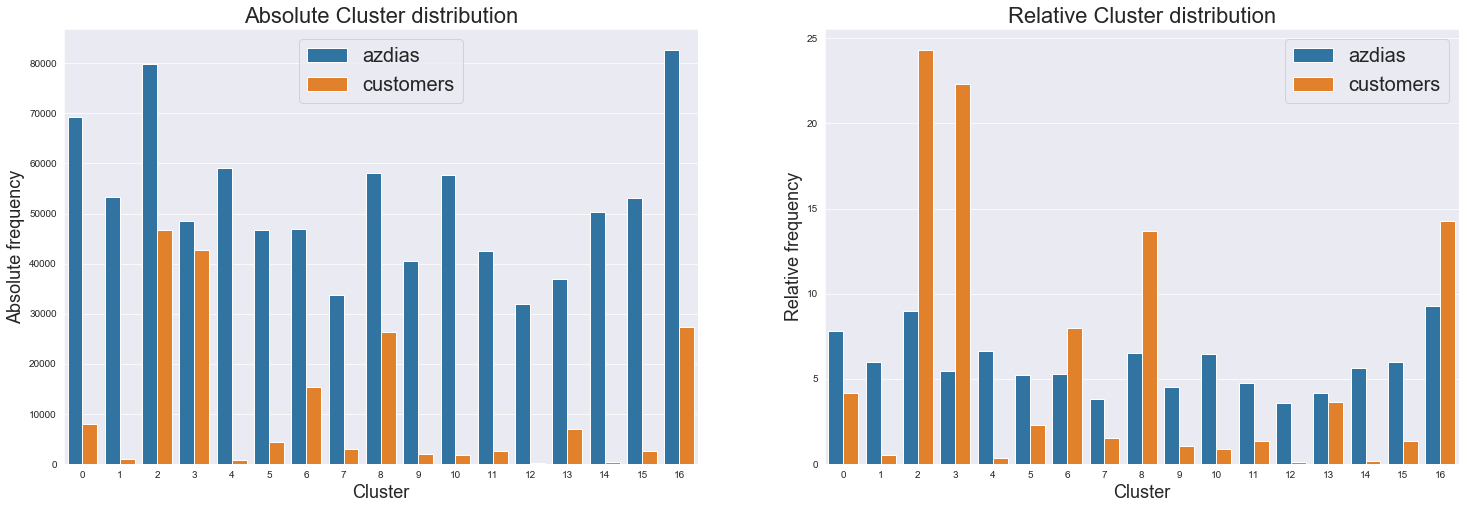

In [54]:
f, axes = plt.subplots(1, 2, figsize=(25, 8))
sns.barplot(x='cluster', hue='class', y='count',data=kmeans_results, ax=axes[0])
axes[0].set_xlabel('Cluster', fontsize=18)
axes[0].set_ylabel('Absolute frequency', fontsize=18)
axes[0].set_title('Absolute Cluster distribution', fontsize=22)
axes[0].legend(fontsize=20)

sns.barplot(x='cluster', hue='class', y='percentage',data=kmeans_results, ax=axes[1])
axes[1].set_xlabel('Cluster', fontsize=18)
axes[1].set_ylabel('Relative frequency', fontsize=18)
axes[1].legend(fontsize=20)
axes[1].set_title('Relative Cluster distribution', fontsize=22);
f.savefig("pictures/cluster_distribution.pdf",format='pdf', bbox_inches='tight')

Next, we investigate which clusters in <span class="mark">customers data</span> are most significant with respect to the <span class="mark">azdias dataframe</span>.

In [55]:
cluster_comparison = pd.DataFrame({'azdias': pd.Series(kmeans_model.labels_).value_counts()/pca_azdias_df.shape[0]*100,
                                  'customers': pd.Series(kmeans_model_customers).value_counts()/pca_customers_df.shape[0]*100})

cluster_comparison['difference'] = abs(cluster_comparison['azdias'] - cluster_comparison['customers'])
cluster_comparison.head()

,azdias,customers,difference
0,7.779888,4.167971,3.611917
1,5.986618,0.544216,5.442403
2,8.964555,24.338906,15.374351
3,5.449714,22.307620,16.857906
4,6.621590,0.365767,6.255823


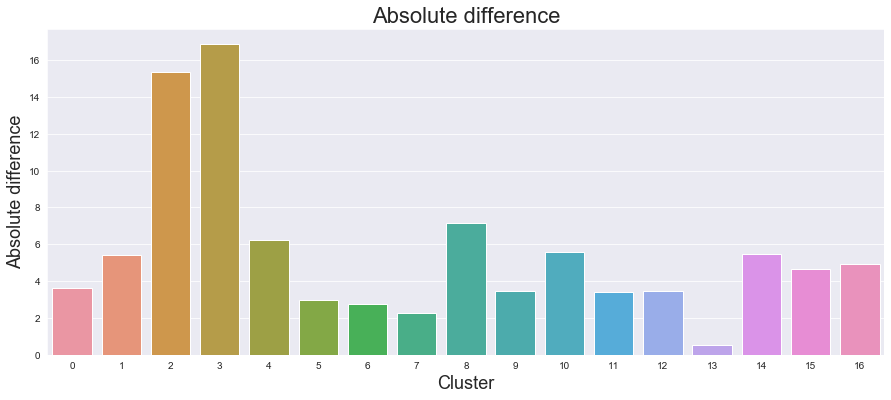

In [183]:
plt.figure(figsize=(15,6))
chart = sns.barplot(x=cluster_comparison.index, y='difference',data=cluster_comparison)
chart.set_ylabel('Absolute difference', fontsize=18)
chart.set_xlabel('Cluster', fontsize=18)
chart.set_title('Absolute difference', fontsize=22);
plt.savefig("pictures/cluster_differences.pdf",format='pdf', bbox_inches='tight')

In [57]:
def inspect_cluster(cluster_num, components_num):
    """
    Inspect specific cluster and display the first 'components_num' weights.
    
    args:
    - cluster_num: cluster to display
    - components_num: number of components sorted by weight to display
    """
    inspect_df = pd.DataFrame()
    inspect_df['pca_abs_weight'] = abs(kmeans_model.cluster_centers_[cluster_num])
    inspect_df['pca_weight'] = kmeans_model.cluster_centers_[cluster_num]
    inspect_df['pca_component'] = range(50)
    result = inspect_df.sort_values(by=['pca_abs_weight'], ascending=[0])[:components_num]
    
    return result

In [58]:
# 3rd largest difference
difference_3rd = cluster_comparison['difference'].sort_values(ascending=False).iloc[2]

# condition to find the three largest difference values
condition_3rd = cluster_comparison['difference'] >= difference_3rd

# find the corresponding clusters

clusters_to_inspect = cluster_comparison.loc[condition_3rd].index.values

In [59]:
for index in clusters_to_inspect:
    print('Cluster: {}'.format(index))
    print(inspect_cluster(index, 10))
    print()

Cluster: 2
    pca_abs_weight  pca_weight  pca_component
2         1.126045   -1.126045              2
8         0.977291   -0.977291              8
0         0.948835   -0.948835              0
6         0.868821   -0.868821              6
10        0.705695   -0.705695             10
1         0.678865   -0.678865              1
4         0.348324   -0.348324              4
11        0.315399    0.315399             11
7         0.246026   -0.246026              7
3         0.219468   -0.219468              3

Cluster: 3
    pca_abs_weight  pca_weight  pca_component
0         2.076285    2.076285              0
3         1.429899    1.429899              3
1         0.495931   -0.495931              1
2         0.397575    0.397575              2
5         0.381997    0.381997              5
7         0.365100    0.365100              7
12        0.187157   -0.187157             12
14        0.132874   -0.132874             14
39        0.116065   -0.116065             39
30        0

## Supervised Learning Model

Now that we've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, we'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [60]:
# read in the training data
mailout_train = pd.read_csv('data/mailout_train.csv')

/opt/anaconda3/envs/DataScience/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [61]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


Next, we apply all the preliminary steps to the training data, which we have conducted on <span class="mark">azdias</span> and <span class="mark">customers</span>.

In [62]:
# Same attributes are sometimes encoded as strings and sometimes as floats, e.g., 1 and '1'
mixed_datatypes = {'CAMEO_DEUG_2015': [str(i) for i in range(1,10)], 
                   'CAMEO_INTL_2015': ['22', '24', '41', '12', '54', '51', '44', '35', '23', 
                                       '25', '14','34', '52', '55', '31', '32', '15', '13',
                                       '43', '33', '45']}

mixed_datatypes_handler([mailout_train], mixed_datatypes)

In [63]:
mailout_train.drop(['EINGEFUEGT_AM'], axis=1, inplace=True)

In [64]:
# Some of the columns have attributes that do not occur in DIAS-Attributes
col_attr_to_replace = {'CAMEO_DEU_2015': 'XX', 'CAMEO_DEUG_2015': 'X', 'CAMEO_INTL_2015': 'XX'}

attributes_to_replace([mailout_train], col_attr_to_replace)

In [65]:
# replace unknown values by np.nan
add_nans([mailout_train], value_meaning)

In [66]:
df_mailout_train_kind = mailout_train[['ALTER_KIND1','ALTER_KIND2','ALTER_KIND3','ALTER_KIND4']]
mailout_train['ALTER_KIND_MEAN'] = np.sum(df_mailout_train_kind, axis=1)

mailout_train['ALTER_KIND_MEAN'].loc[df_mailout_train_kind.isnull().sum(axis=1) == 2] = mailout_train[df_mailout_train_kind.isnull().sum(axis=1) == 2]['ALTER_KIND_MEAN']/2
mailout_train['ALTER_KIND_MEAN'].loc[df_mailout_train_kind.isnull().sum(axis=1) == 1] = mailout_train[df_mailout_train_kind.isnull().sum(axis=1) == 1]['ALTER_KIND_MEAN']/3
mailout_train['ALTER_KIND_MEAN'].loc[df_mailout_train_kind.isnull().sum(axis=1) == 0] = mailout_train[df_mailout_train_kind.isnull().sum(axis=1) == 0]['ALTER_KIND_MEAN']/4

mailout_train.drop(['ALTER_KIND1','ALTER_KIND2','ALTER_KIND3','ALTER_KIND4'], axis=1, inplace=True)

/opt/anaconda3/envs/DataScience/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [67]:
#remove attributes that we have discarded from azdias and customers
mailout_train.drop(attributes_to_discard, axis=1, inplace=True)
print(attributes_to_discard)

['ALTER_HH', 'EXTSEL992', 'TITEL_KZ', 'KK_KUNDENTYP', 'AGER_TYP', 'KBA05_BAUMAX']


In [68]:
replace_nans([mailout_train])

There are no missing values anymore.


In [69]:
cat_cols_mailout_train = mailout_train.select_dtypes(include=['object']).columns.values
mailout_train = pd.get_dummies(mailout_train, columns=cat_cols_mailout_train)

We store the responses in a new variable and discard the response column from the training data.

In [70]:
response = mailout_train['RESPONSE']
mailout_train.drop(['RESPONSE'], axis=1, inplace=True)

In [71]:
common_attributes = set(customers.columns).intersection(set(mailout_train.columns))
print("Number of attributes for 'azdias': {}".format(len(azdias.columns)))
print("Number of attributes for 'customers': {}".format(len(customers.columns)))
print("Number of attributes for 'mailout_train': {}".format(len(mailout_train.columns)))
print("Number of common attributes: {}".format(len(common_attributes)))

Number of attributes for 'azdias': 434
Number of attributes for 'customers': 434
Number of attributes for 'mailout_train': 434
Number of common attributes: 434


In [72]:
scaler = MinMaxScaler()

mailout_train_scaled = pd.DataFrame(scaler.fit_transform(mailout_train.loc[:, mailout_train.columns != 'LNR'].astype(float)))

mailout_train_scaled.columns = mailout_train.columns[1:]
mailout_train_scaled.index = mailout_train.index

mailout_train_scaled.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,OST_WEST_KZ_O,OST_WEST_KZ_W
0,0.000,0.32,0.034247,0.000000,0.0,0.041667,0.035230,0.0,0.250,0.666667,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.375,0.52,0.002283,0.000000,0.0,0.083333,0.002710,0.0,0.125,0.666667,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.000,0.28,0.000000,0.002479,0.0,0.000000,0.002710,0.0,0.375,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.000,0.24,0.009132,0.000000,0.0,0.083333,0.010840,0.0,0.375,0.166667,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.000,0.36,0.121005,0.000000,0.0,0.041667,0.119241,0.0,0.250,0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [73]:
pca_mailout_train = pca.transform(mailout_train_scaled)
pca_mailout_train_df = pd.DataFrame(pca_mailout_train)
pca_mailout_train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-1.412581,-1.077231,1.935399,1.711742,-0.786178,-0.212870,0.520176,-0.676089,-0.645235,-0.092454,...,0.280159,-0.362983,0.095689,-0.823805,-0.212160,-0.365141,-0.272518,0.245333,-0.617088,-0.201901
1,2.543427,-0.688047,0.327944,-0.939047,-0.916165,-0.831219,0.824574,-0.546464,0.075555,-0.252093,...,-0.015083,-0.114620,0.469829,0.175503,-0.219911,-0.033557,-0.286350,-0.432561,-0.516702,0.270888
2,1.371054,-1.390990,1.883423,-0.145583,0.936714,1.824178,-0.672139,0.091010,-0.209997,-0.144435,...,-0.841794,-0.335517,-0.410833,-0.358627,-0.220765,0.033908,0.141525,0.372946,-0.372876,-0.451568
3,0.753300,-2.106398,0.123696,3.391512,-0.739148,0.439145,-0.266740,0.568448,1.071360,-0.418721,...,0.689529,-0.500693,-0.493018,-0.294529,0.311990,-0.006389,0.133628,0.659778,-0.346053,-0.311352
4,0.241031,-1.030647,1.313097,1.817479,0.892187,1.261252,-0.077284,-0.791954,0.174827,0.945707,...,-0.097968,0.229577,-0.008894,-0.095186,-0.103243,0.343530,-0.692366,-0.086444,-0.314038,-0.469343


In [74]:
kmeans_model_mailout_train = kmeans_model.predict(pca_mailout_train_df)

Now, we'll start building our final training dataframe that will be used to train our classification models.

In [75]:
df_train = pd.concat([pd.Series(kmeans_model_mailout_train, name='KmeansPrediction'),response], axis=1)
df_train.head()

,KmeansPrediction,RESPONSE
0,0,0
1,8,0
2,11,0
3,13,0
4,13,0


One can see from the figure below that the response behavior is quite <span class="burk">unbalanced</span>. We have to account for this fact in our classification model.

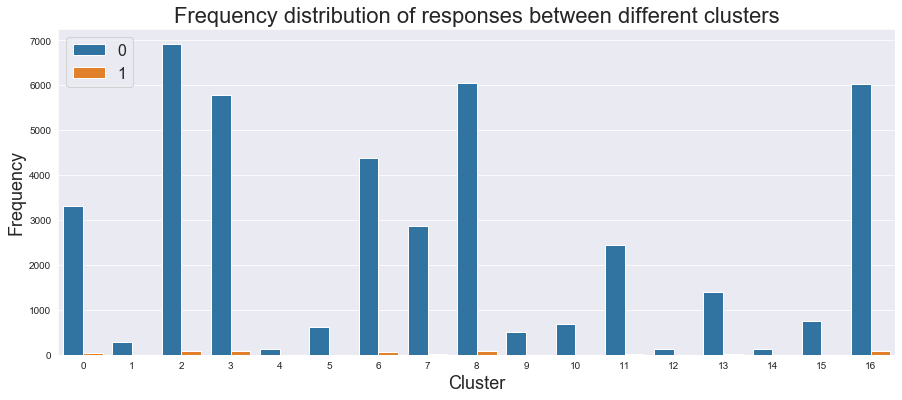

In [76]:
plt.figure(figsize=(15,6))
chart = sns.countplot(x="KmeansPrediction", hue="RESPONSE", data=df_train)
chart.set_xlabel('Cluster', fontsize=18)
chart.set_ylabel('Frequency', fontsize=18)
chart.legend(fontsize=16)
chart.set_title('Frequency distribution of responses between different clusters', fontsize=22);
plt.savefig("pictures/cluster_distributionYN.pdf",format='pdf', bbox_inches='tight')

In [77]:
def create_cluster_probability(clustermember, responses, num_cluster):
    """
    1) For each cluster, create a cluster probability indicating how likely it is for a 
    customer to be in a specific cluster.
    2) For each cluster, create a scaled probability of a positive response behavior.
    3) For each cluster, create a scaled probability of a positive response behavior in that cluster.
    
    args:
    - clustermember: series object indicating the cluster membership of each individual
    - responses: series object indicating the response (0,1) of each individual
    - num_cluster: number of clusters
    """
    table = clustermember.groupby(responses).value_counts()
    probaYes = {cluster: table[1][cluster]/(table[1][cluster]+table[0][cluster]) 
                 for cluster in range(num_cluster)}

    factor = 1/sum(probaYes.values())
    probaYes = {key: value*factor for key, value in probaYes.items()}
    
    probaCluster = {cluster: (table[1][cluster]+table[0][cluster])/len(clustermember) 
                     for cluster in range(opt_k)}
    
    proba = {cluster: probaYes[cluster]*probaCluster[cluster] for cluster in range(opt_k)}
    
    factor = 1/sum(proba.values())
    proba = {key: value*factor for key, value in proba.items()}
    
    return probaYes, probaCluster, proba

In [78]:
probYes, probCluster, prob = create_cluster_probability(df_train['KmeansPrediction'], df_train['RESPONSE'], opt_k)

In [79]:
probYes

{0: 0.0749752139120178,
 1: 0.03934371848950329,
 2: 0.06649583172829382,
 3: 0.09051930473345526,
 4: 0.08184642167524407,
 5: 0.009131074730870065,
 6: 0.06718142299162867,
 7: 0.05430004730996823,
 8: 0.07403405129851512,
 9: 0.0553999988612077,
 10: 0.03259581328345476,
 11: 0.05224839438790399,
 12: 0.040923210837622036,
 13: 0.07874269501059297,
 14: 0.08305896125561807,
 15: 0.02218923437237818,
 16: 0.07701460512172599}

In [80]:
probCluster

{0: 0.0783250314231181,
 1: 0.006633769377589497,
 2: 0.16288813369954844,
 3: 0.13695824216749686,
 4: 0.003188864577999162,
 5: 0.01429169964154369,
 6: 0.1029514454634328,
 7: 0.06729202551091662,
 8: 0.1427773381127508,
 9: 0.011777850193193985,
 10: 0.016014152041338856,
 11: 0.05744611517154695,
 12: 0.003188864577999162,
 13: 0.03314557050416647,
 14: 0.0031423118104371307,
 15: 0.017643498906009962,
 16: 0.1423350868209115}

In [81]:
prob

{0: 0.08458646616541354,
 1: 0.0037593984962406017,
 2: 0.15601503759398497,
 3: 0.17857142857142858,
 4: 0.0037593984962406017,
 5: 0.0018796992481203013,
 6: 0.09962406015037595,
 7: 0.052631578947368425,
 8: 0.15225563909774437,
 9: 0.009398496240601505,
 10: 0.007518796992481202,
 11: 0.04323308270676692,
 12: 0.0018796992481203009,
 13: 0.03759398496240602,
 14: 0.0037593984962406026,
 15: 0.005639097744360904,
 16: 0.15789473684210528}

In [82]:
df_train['ClusterProb'] = [None]*df_train.shape[0]
df_train['ProbYes'] = [None]*df_train.shape[0]
df_train['Prob'] = [None]*df_train.shape[0]

for i in range(opt_k):
    df_train['ClusterProb'].loc[df_train['KmeansPrediction'] == i] = probCluster[i]
    df_train['ProbYes'].loc[df_train['KmeansPrediction'] == i] = probYes[i]
    df_train['Prob'].loc[df_train['KmeansPrediction'] == i] = prob[i]

/opt/anaconda3/envs/DataScience/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [83]:
df_train.head()

,KmeansPrediction,RESPONSE,ClusterProb,ProbYes,Prob
0,0,0,0.078325,0.0749752,0.0845865
1,8,0,0.142777,0.0740341,0.152256
2,11,0,0.0574461,0.0522484,0.0432331
3,13,0,0.0331456,0.0787427,0.037594
4,13,0,0.0331456,0.0787427,0.037594


In addition to the features <span class="girk">ClusterProb, ProbYes</span> and <span class="girk">Prob</span>, which we created based on our unsupervised learning model, we include some additional features of <span class="mark">mailout_train_scaled</span> based on univariate feature selection using F-test for feature scoring.

In [84]:
# define univariate feature selection object using F-test for feature scoring
selector = SelectKBest(score_func=f_classif, k=50)
X = selector.fit_transform(mailout_train_scaled, response)
# which cols of mailout_train_scaled have been chosen
selected_cols = mailout_train_scaled.columns.values[selector.get_support()]
# what are the scores of each column
selected_scores = selector.scores_[selector.get_support()]
selection = {'Col_names': selected_cols, 'Score': selected_scores}

selection_results = pd.DataFrame(selection).sort_values(by=['Score'], ascending=False)
selection_results

,Col_names,Score
12,D19_KONSUMTYP_MAX,70.204419
13,D19_SOZIALES,58.569819
11,D19_KONSUMTYP,58.497944
40,RT_SCHNAEPPCHEN,42.700378
39,RT_KEIN_ANREIZ,14.407308
25,KBA13_CCM_3000,13.852625
17,KBA05_CCM4,12.698379
38,PRAEGENDE_JUGENDJAHRE,12.475684
36,KBA13_SITZE_5,11.655849
24,KBA13_CCM_2501,11.526062


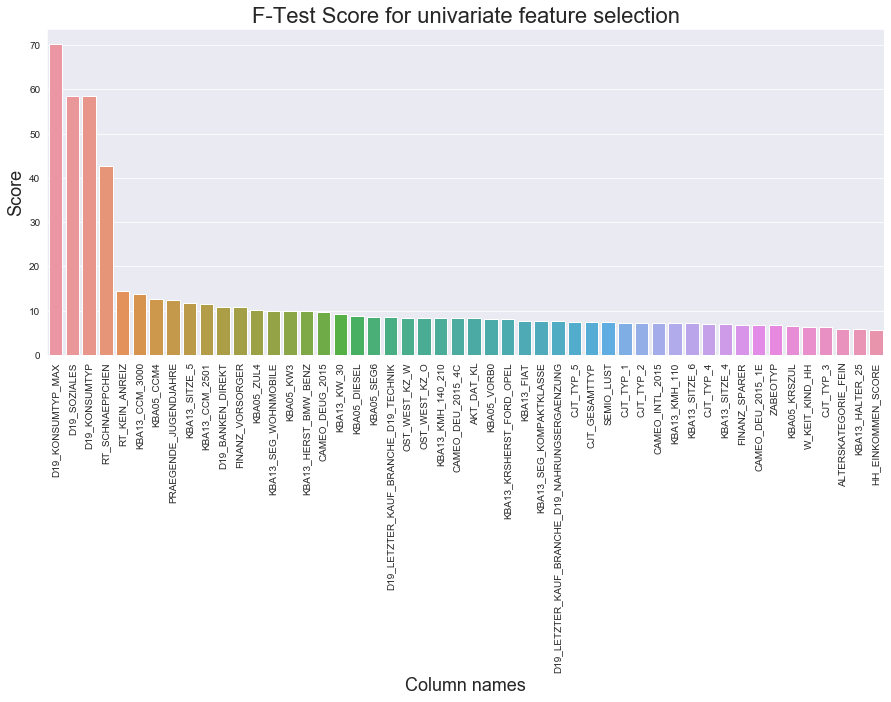

In [85]:
plt.figure(figsize=(15,6))
chart = sns.barplot(x='Col_names', y='Score', data=selection_results)
chart.set_xlabel('Column names', fontsize=18)
chart.set_ylabel('Score', fontsize=18)
chart.set_title('F-Test Score for univariate feature selection', fontsize=22)
chart.set_xticklabels(selection_results['Col_names'], rotation=90);
plt.savefig("pictures/ftest.pdf",format='pdf', bbox_inches='tight')

Only a few attributes have a F-test score of more than 50. Therefore, we will include them in our training data along with the feature <span class="mark">Prob</span>.

In [89]:
X_1 = mailout_train_scaled[selection_results.loc[selection_results['Score'] > 50]['Col_names'].values]
X_2 = df_train[['Prob']]
X = pd.concat([X_1, X_2], axis=1)
X.head()

,D19_KONSUMTYP_MAX,D19_SOZIALES,D19_KONSUMTYP,Prob
0,0.125,0.2,0.250,0.0845865
1,0.375,1.0,0.000,0.152256
2,0.125,0.4,0.125,0.0432331
3,0.125,0.2,0.250,0.037594
4,0.125,0.2,0.125,0.037594


In [90]:
y = df_train['RESPONSE']

In [161]:
factor = 1/sum(X['Prob'].values)
weight = [value*factor for value in X['Prob'].values]

Now, we are going to test different classification models on our training data.

In [166]:
def model_eval(classifier, X, y, name):
    """
    Displays the ROC curve and score w.r.t. a given classifier, a dataframe X and a series
    of responses y.
    
    args:
    - classifier: scikit learn classifier object
    - X: pandas Dataframe
    - y: pandas Series (responses)
    - name: name of classifier
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict_proba(X_test)[:,1]
    clf_disp = plot_roc_curve(classifier, X_test, y_test, name=name)
    clf_disp.figure_.suptitle("ROC curve")
    plt.savefig("pictures/{}.pdf".format(name),format='pdf', bbox_inches='tight')
    print("AUC Score:", roc_auc_score(y_test, y_pred, average='weighted'))

### Logistic regression

AUC Score: 0.6799533965115625


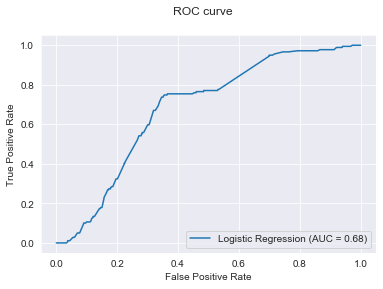

In [180]:
lr = LogisticRegression()
model_eval(lr, X, y, "Logistic Regression")

### Random forest classifier

AUC Score: 0.7717185305734129


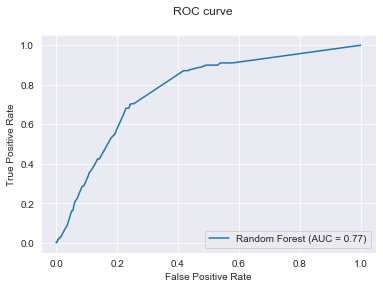

In [181]:
rf = RandomForestClassifier()
model_eval(rf, X, y, "Random Forest")

### K-nearest neighbor classifier

AUC Score: 0.7203309813430409


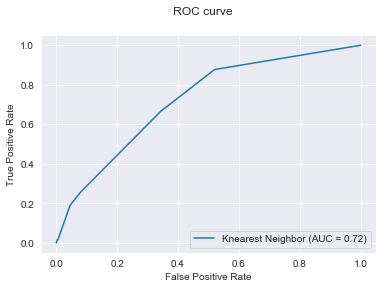

In [172]:
kn = KNeighborsClassifier(n_neighbors=75)
model_eval(kn, X, y, "Knearest Neighbor")

### AdaBoost classifier

AUC Score: 0.7901575970510264


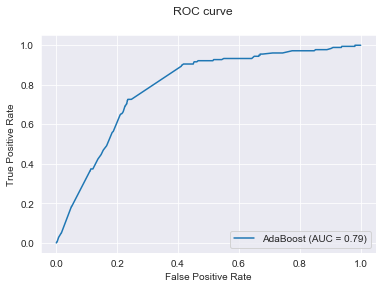

In [176]:
ada = AdaBoostClassifier()
model_eval(ada, X, y, "AdaBoost")

### Decision tree classifier

AUC Score: 0.7689250349486256


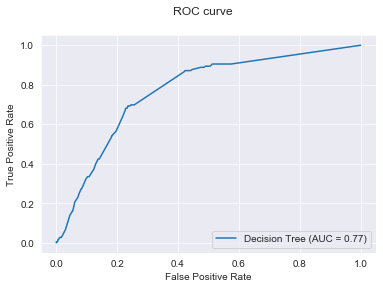

In [182]:
dt = DecisionTreeClassifier()
model_eval(dt, X, y, "Decision Tree")

### Quadratic discriminant analysis

AUC Score: 0.772381786248898


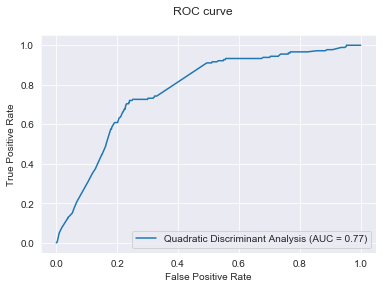

In [178]:
qda = QuadraticDiscriminantAnalysis()
model_eval(qda, X, y, "Quadratic Discriminant Analysis")

### Gradient boosting classifier

AUC Score: 0.7895103042076828


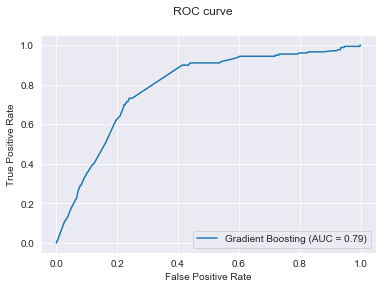

In [179]:
classifier = GradientBoostingClassifier()
model_eval(classifier, X, y, "Gradient Boosting")

## Parameter Tuning

In the last section, we have tested the performance of some models on our training data. For those who performed best, we will try to improve the AUC score by tuning the parameters. 

In [105]:
def parameter_tuning(classifier, parameters, cv, X, y, name):
    """
    Receives a classifier along with a parameter grid to conduct hyperparameter tuning.
    Prints the best parameters along with the grid search results. Calls the function
    model_eval w.r.t. the best estimator.
    Returns the best estimator.
    
    args:
    - classifier: scikit learn classifier object
    - parameters: parameter grid for tuning
    - cv: cross validation
    - X: pandas Dataframe
    - y: pandas Series (responses)
    - name: name of classifier
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
    
    grid = GridSearchCV(classifier, param_grid=parameters, cv=cv, scoring='roc_auc')
    grid.fit(X_test, y_test)
    
    print('Best parameters:', grid.best_params_)
    model_eval(grid.best_estimator_, X, y, name=name)
    display(pd.DataFrame(grid.cv_results_))
    
    return grid.best_estimator_

### Decision tree classifier

Best parameters: {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
AUC Score: 0.7800383586856363


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,param_class_weight,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.010736,0.000662,0.003362,0.000220,0,balanced,gini,10,1,2,"{'ccp_alpha': 0.0, 'class_weight': 'balanced',...",0.735422,0.720164,0.753527,0.688852,0.768131,0.733219,0.027477,4
1,0.010364,0.000276,0.003324,0.000269,0,balanced,gini,10,1,5,"{'ccp_alpha': 0.0, 'class_weight': 'balanced',...",0.734767,0.720164,0.753527,0.688852,0.768131,0.733088,0.027468,5
2,0.010198,0.000179,0.003178,0.000116,0,balanced,gini,10,1,10,"{'ccp_alpha': 0.0, 'class_weight': 'balanced',...",0.734767,0.718259,0.752852,0.688852,0.767457,0.732437,0.027383,10
3,0.011321,0.002203,0.003372,0.000223,0,balanced,gini,10,2,2,"{'ccp_alpha': 0.0, 'class_weight': 'balanced',...",0.735094,0.718576,0.752852,0.688852,0.767457,0.732566,0.027357,8
4,0.009857,0.000671,0.002957,0.000156,0,balanced,gini,10,2,5,"{'ccp_alpha': 0.0, 'class_weight': 'balanced',...",0.734767,0.718576,0.752852,0.688852,0.767457,0.732501,0.027351,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,0.011040,0.000866,0.003934,0.001018,0.5,balanced,entropy,None,2,5,"{'ccp_alpha': 0.5, 'class_weight': 'balanced',...",0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,136
266,0.013724,0.000380,0.003295,0.000319,0.5,balanced,entropy,None,2,10,"{'ccp_alpha': 0.5, 'class_weight': 'balanced',...",0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,136
267,0.012067,0.001511,0.003120,0.000558,0.5,balanced,entropy,None,4,2,"{'ccp_alpha': 0.5, 'class_weight': 'balanced',...",0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,136
268,0.009984,0.000197,0.002665,0.000150,0.5,balanced,entropy,None,4,5,"{'ccp_alpha': 0.5, 'class_weight': 'balanced',...",0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,136


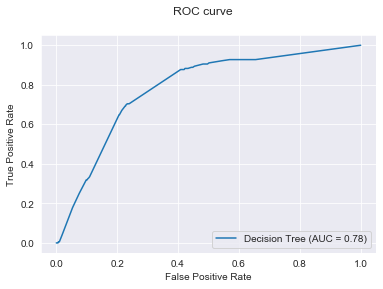

In [106]:
dt_clf = DecisionTreeClassifier()
parameters = {'criterion': ['gini', 'entropy'],
             'max_depth': [10, 50, 90, 200, None],
             'min_samples_split': [2, 5, 10],
             'min_samples_leaf': [1, 2, 4],
             'class_weight': ['balanced'],
              'ccp_alpha': [0.0, 0.1, 0.5]
             }

best = parameter_tuning(dt_clf, parameters, 5, X, y, 'Decision Tree')

### AdaBoost classifier

Now, we use the previously tuned decision tree classifier as a base estimator for Ada boost classifier. 

Best parameters: {'learning_rate': 0.05, 'n_estimators': 100}
AUC Score: 0.7825999941735663


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.225487,0.014351,0.043836,0.001238,0.001,50,"{'learning_rate': 0.001, 'n_estimators': 50}",0.674952,0.626847,0.614298,0.638699,0.026141,15
1,0.406938,0.003386,0.073774,0.000135,0.001,100,"{'learning_rate': 0.001, 'n_estimators': 100}",0.674952,0.660416,0.614298,0.649889,0.025856,14
2,1.212566,0.006369,0.215238,0.001106,0.001,300,"{'learning_rate': 0.001, 'n_estimators': 300}",0.777925,0.705508,0.679342,0.720925,0.041697,13
3,0.229593,0.022352,0.042603,0.004641,0.05,50,"{'learning_rate': 0.05, 'n_estimators': 50}",0.833374,0.762318,0.737773,0.777822,0.040539,5
4,0.424121,0.012885,0.090625,0.019205,0.05,100,"{'learning_rate': 0.05, 'n_estimators': 100}",0.824420,0.773825,0.746823,0.781689,0.032163,1
5,1.335093,0.154031,0.231753,0.026348,0.05,300,"{'learning_rate': 0.05, 'n_estimators': 300}",0.819795,0.767029,0.746860,0.777895,0.030751,4
6,0.206731,0.002856,0.038418,0.000079,0.1,50,"{'learning_rate': 0.1, 'n_estimators': 50}",0.824413,0.770149,0.748171,0.780911,0.032042,2
7,0.474766,0.028212,0.091598,0.015147,0.1,100,"{'learning_rate': 0.1, 'n_estimators': 100}",0.825406,0.766726,0.747089,0.779740,0.033271,3
8,1.343501,0.039761,0.242879,0.024673,0.1,300,"{'learning_rate': 0.1, 'n_estimators': 300}",0.799089,0.766374,0.741818,0.769094,0.023459,6
9,0.220907,0.018616,0.041110,0.004411,0.6,50,"{'learning_rate': 0.6, 'n_estimators': 50}",0.795490,0.764670,0.738327,0.766162,0.023360,7


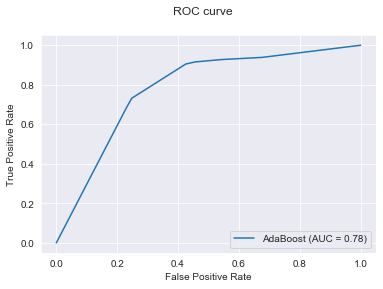

In [131]:
parameters = {
 'n_estimators': [50, 100, 300],
 'learning_rate' : [0.001, 0.05, 0.1, 0.6, 1]
 }

best_final = parameter_tuning(AdaBoostClassifier(), parameters, 3, X, y, 'AdaBoost')

## Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [132]:
mailout_test = pd.read_csv('data/mailout_test.csv')

/opt/anaconda3/envs/DataScience/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [133]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [134]:
# Same attributes are sometimes encoded as strings and sometimes as floats, e.g., 1 and '1'
mixed_datatypes = {'CAMEO_DEUG_2015': [str(i) for i in range(1,10)], 
                   'CAMEO_INTL_2015': ['22', '24', '41', '12', '54', '51', '44', '35', '23', 
                                       '25', '14','34', '52', '55', '31', '32', '15', '13',
                                       '43', '33', '45']}

mixed_datatypes_handler([mailout_test], mixed_datatypes)

In [135]:
mailout_test.drop(['EINGEFUEGT_AM'], axis=1, inplace=True)

In [136]:
# Some of the columns have attributes that do not occur in DIAS-Attributes
col_attr_to_replace = {'CAMEO_DEU_2015': 'XX', 'CAMEO_DEUG_2015': 'X', 'CAMEO_INTL_2015': 'XX'}

attributes_to_replace([mailout_test], col_attr_to_replace)

In [137]:
# replace unknown values by np.nan
add_nans([mailout_test], value_meaning)

In [138]:
df_mailout_test_kind = mailout_test[['ALTER_KIND1','ALTER_KIND2','ALTER_KIND3','ALTER_KIND4']]
mailout_test['ALTER_KIND_MEAN'] = np.sum(df_mailout_test_kind, axis=1)

mailout_test['ALTER_KIND_MEAN'].loc[df_mailout_test_kind.isnull().sum(axis=1) == 2] = mailout_test[df_mailout_test_kind.isnull().sum(axis=1) == 2]['ALTER_KIND_MEAN']/2
mailout_test['ALTER_KIND_MEAN'].loc[df_mailout_test_kind.isnull().sum(axis=1) == 1] = mailout_test[df_mailout_test_kind.isnull().sum(axis=1) == 1]['ALTER_KIND_MEAN']/3
mailout_test['ALTER_KIND_MEAN'].loc[df_mailout_test_kind.isnull().sum(axis=1) == 0] = mailout_test[df_mailout_test_kind.isnull().sum(axis=1) == 0]['ALTER_KIND_MEAN']/4

mailout_test.drop(['ALTER_KIND1','ALTER_KIND2','ALTER_KIND3','ALTER_KIND4'], axis=1, inplace=True)

/opt/anaconda3/envs/DataScience/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [139]:
#remove attributes that we have discarded from azdias and customers
mailout_test.drop(attributes_to_discard, axis=1, inplace=True)
print(attributes_to_discard)

['ALTER_HH', 'EXTSEL992', 'TITEL_KZ', 'KK_KUNDENTYP', 'AGER_TYP', 'KBA05_BAUMAX']


In [140]:
replace_nans([mailout_test])

There are no missing values anymore.


In [141]:
cat_cols_mailout_test = mailout_test.select_dtypes(include=['object']).columns.values
mailout_test = pd.get_dummies(mailout_test, columns=cat_cols_mailout_test)

In [142]:
common_attributes = set(customers.columns).intersection(set(mailout_test.columns))
print("Number of attributes for 'azdias': {}".format(len(azdias.columns)))
print("Number of attributes for 'customers': {}".format(len(customers.columns)))
print("Number of attributes for 'mailout_test': {}".format(len(mailout_test.columns)))
print("Number of common attributes: {}".format(len(common_attributes)))

Number of attributes for 'azdias': 434
Number of attributes for 'customers': 434
Number of attributes for 'mailout_test': 434
Number of common attributes: 434


In [143]:
scaler = MinMaxScaler()

mailout_test_scaled = pd.DataFrame(scaler.fit_transform(mailout_test.loc[:, mailout_test.columns != 'LNR'].astype(float)))

mailout_test_scaled.columns = mailout_test.columns[1:]
mailout_test_scaled.index = mailout_test.index

mailout_test_scaled.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,OST_WEST_KZ_O,OST_WEST_KZ_W
0,0.00,0.24,0.005277,0.0,0.0,0.142857,0.005333,0.0,0.250,0.833333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.00,0.00,0.052770,0.0,0.0,0.071429,0.056000,0.0,0.375,1.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.00,0.44,0.005277,0.0,0.0,0.285714,0.005333,0.0,0.375,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.75,0.00,0.002639,0.0,0.0,0.000000,0.002667,0.0,0.375,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.00,0.52,0.002639,0.0,0.0,0.285714,0.002667,0.0,0.250,0.833333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [144]:
pca_mailout_test = pca.transform(mailout_test_scaled)
pca_mailout_test_df = pd.DataFrame(pca_mailout_test)
pca_mailout_test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,2.070160,-1.193392,0.981047,2.525935,0.896454,1.043000,-0.193478,-0.996555,-0.956961,-0.219074,...,-0.071370,-0.080845,0.302026,0.331796,-0.608489,-0.219577,-0.011490,-0.152469,-0.436441,-0.140214
1,-0.557746,-1.203658,1.315348,0.636445,0.587310,-0.542919,0.803112,-1.142272,0.026495,0.360053,...,-0.215045,-0.648370,-0.023439,0.108149,-0.252543,-1.043730,0.514146,0.080733,-0.071934,-0.338009
2,0.795406,-1.896702,0.579175,1.276876,-0.623573,0.397987,0.549906,2.020937,0.012726,-0.314312,...,0.029714,0.438601,-0.298231,0.006036,0.060509,0.672839,0.365950,0.730647,0.217074,-0.182963
3,0.222003,-1.772703,1.421525,-1.248368,-1.088582,0.315749,-0.658373,0.698057,0.093806,0.060741,...,-0.315444,-0.416370,0.266129,0.264333,-0.465360,0.425236,-0.137057,-0.496914,0.080882,-0.068802
4,4.175304,0.844557,0.724527,-0.263834,-0.920600,-1.025725,1.798451,-0.468162,-1.121325,0.645000,...,-0.697004,-0.708785,-0.128276,-0.405380,0.165443,-0.203289,0.296337,0.114038,0.246785,0.231249


In [145]:
kmeans_model_mailout_test = pd.Series(kmeans_model.predict(pca_mailout_test_df), name='KmeansPrediction')

In [146]:
# cluster probability
p = {i: kmeans_model_mailout_test.value_counts()[i]/mailout_test.shape[0] for i in range(opt_k)}

In [147]:
pp = {i: p[i]*probYes[i] for i in range(opt_k)}
factor = 1/sum(pp.values())
pp = {key: value*factor for key, value in pp.items()}

In [148]:
df_test = pd.DataFrame(kmeans_model_mailout_test)

df_test['ClusterProb'] = [None]*df_test.shape[0]
df_test['ProbYes'] = [None]*df_test.shape[0]
df_test['Prob'] = [None]*df_test.shape[0]

for i in range(opt_k):
    df_test['ClusterProb'].loc[df_test['KmeansPrediction'] == i] = p[i]
    df_test['ProbYes'].loc[df_test['KmeansPrediction'] == i] = probYes[i]
    df_test['Prob'].loc[df_test['KmeansPrediction'] == i] = pp[i]
    
df_test.head()

/opt/anaconda3/envs/DataScience/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,KmeansPrediction,ClusterProb,ProbYes,Prob
0,3,0.135293,0.0905193,0.176475
1,0,0.0758527,0.0749752,0.0819512
2,16,0.140966,0.0770146,0.156442
3,11,0.0580394,0.0522484,0.0436981
4,8,0.145542,0.0740341,0.15527


In [149]:
Y_1 = mailout_test_scaled[selection_results.loc[selection_results['Score'] > 50]['Col_names'].values]
Y_2 = df_test[['Prob']]
Y = pd.concat([Y_1, Y_2], axis=1)

In [150]:
submission = pd.Series(best_final.predict_proba(Y)[:,1], name='RESPONSE')
submission = pd.concat([mailout_test['LNR'], submission], axis=1)
submission.to_csv('submission', index=False)